# Model Tuning

In this notebook, I'll be following up on the top-scoring models of the last trials, and attempting to optimize the hyperparameters for even better test scores.

In [24]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.simplefilter('ignore') # Ignoring warnings in this notebook to avoid endless convergence issue scrolling

pd.options.display.max_colwidth = 200

In [25]:
reddit = pd.read_csv('../datasets/reddit_slimmed_no_https.csv')
reddit.drop(columns='Unnamed: 0', inplace=True)
reddit['subreddit_class'] = reddit['subreddit_class'].map({'ohio': 0, 'ihateohio': 1})
reddit.head(1)

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,0,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48


In [26]:
# Reading in the model trials dataframe to see which scores performed the best and which models to further test on

model_trials = pd.read_csv('../datasets/model_trials_no_https.csv')
model_trials.drop(columns='Unnamed: 0', inplace=True)
model_trials.head(3)

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.963268,0.793413,0.898801,0.847305
1,TfVec Logistic Regression,0.929535,0.766467,0.870315,0.826347
2,CVec Mn Naive Bayes,0.943778,0.790419,0.897301,0.829341


---

## Top Performing Models

In [29]:
top_models = model_trials[['model_used', 'selftext_test_score']].sort_values(by=['selftext_test_score'], ascending=False).head(10)
top_models['vec_flag'] = [1 if 'CVec' in s else 0 for s in top_models['model_used']]

top_models

,model_used,selftext_test_score,vec_flag
0,CVec Logistic Regression,0.847305,1
2,CVec Mn Naive Bayes,0.829341,1
16,CVec Gradient Boosting,0.829341,1
13,TfVec AdaBoosting,0.829341,0
12,CVec AdaBoosting,0.829341,1
1,TfVec Logistic Regression,0.826347,0
17,TfVec Gradient Boosting,0.820359,0
6,CVec Decision Tree,0.817365,1
11,TfVec Bagging,0.817365,0
10,CVec Bagging,0.814371,1


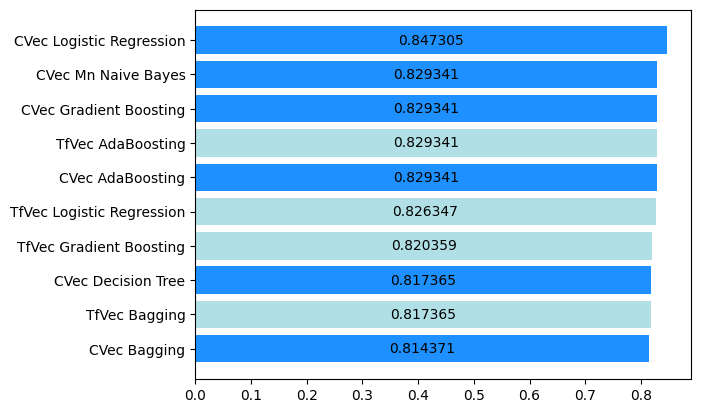

In [30]:
fig, ax = plt.subplots()

colors = ['dodgerblue' if num == 1 else 'powderblue' for num in top_models['vec_flag']]
tm = ax.barh(top_models['model_used'][::-1], width=top_models['selftext_test_score'][::-1], color=colors[::-1])
ax.bar_label(tm, label_type='center')
plt.show();

We can see that four out of the five top-scoring models used CountVectorizer, but the top ten is an almost even split. In the coming model tuning, I'll be testing both vectorizers in all models (with added hyperparameter tuning) to see what performs the best.

Because all of these scores came from using the selftext column (as opposed to using the title column) as X, I'll be moving forward with this as the only predictor variable. 

---

## Building a Function to GridSearch Models

Similar to the model trials function, I'll be writing another that takes a few extra arguments and will grid search over the updated pipelines. 

In [62]:
grid_search_df = pd.DataFrame(columns=['model_used', 'cross_val_score', 'train_score', 'test_score', 'misclass_rate'])

In [63]:
def grid_search(pipe, pipe_params, model_id):

    '''Setting X and y, then splitting into train and test sets'''
    X = reddit['selftext']
    y = reddit['subreddit_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    '''Instantiating GridSearchCV'''
    gs = GridSearchCV(pipe, param_grid=pipe_params, n_jobs= -1, verbose=1, cv = 3)
    gs.fit(X_train, y_train)

    '''GridSearch-specific values'''
    cross_val_score = gs.best_score_
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    best_params = gs.best_params_
    best_estimator = gs.best_estimator_

    '''Calculating accuracy and misclassification rates'''
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    misclass = 1 - acc

    '''Ensuring that models with more parameters can be appended to grid_search_df'''
    for i in range(len(best_params)):
        if f'best_param_{i+1}' not in grid_search_df.columns:
            grid_search_df[f'best_param_{i+1}'] = '-'

    '''Adding the best model scores and hyperparameters to the list of model attributes'''
    model_list = [model_id, cross_val_score, train_score, test_score, misclass]
    for k, v in best_params.items():
        model_list.append((k,v))

    '''Ensuring that models with less parameters can be appended to grid_search_df'''
    if len(model_list) < len(grid_search_df.columns):
        extra_cols = len(grid_search_df.columns) - len(model_list)
        for i in range(extra_cols):
            count = extra_cols
            filler = []
            while count > 0:
                filler.append('-')
                count -= 1
        model_list.extend(filler)        

    '''Appending all numbers and params to the dataframe'''
    grid_search_df.loc[len(grid_search_df.index)] = model_list

    '''Output will show me all scores to see how they compare to each other'''
    print(f'Best Params: {best_params}  \n')
    print(f'Best Estimator Cross Val Score: {round(cross_val_score, 5)}')
    print(f'{model_id} Training Score: {round(train_score, 5)}')
    print(f'{model_id} Testing Score: {round(test_score, 5)}')
    print(f'Misclassification Rate: {round(misclass, 5)} \n')

    '''Returning a confusion matrix'''
    print('Best estimator confusion matrix:')
    if test_score < 0.8:
        return plot_confusion_matrix(best_estimator, X_test, y_test, cmap='bone', values_format='d', display_labels=['ohio', 'ihateohio']);
    else:
        return plot_confusion_matrix(best_estimator, X_test, y_test, cmap='coolwarm', values_format='d', display_labels=['ohio', 'ihateohio']);

Again, I'll be defining the pipeline and hyperparameters I want to use in each model, and the function will output the best-performing model's parameters, all relevant scores, and a confusion matrix showing the distribution of predictions.

I think the matrices are useful in visualizing where each model is underperforming, and can also help identify if there are patterns with some harder-to-classify posts.

---

## Logistic Regression

In [64]:
cvec_lr = Pipeline([
        ('cvec', CountVectorizer()),
        ('lr', LogisticRegression(max_iter= 50_000, solver='saga', random_state=42))
])

cvec_lr_params = {
    'cvec__max_features': [1500, 2000, 3000],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.7, .8],
    'lr__C': [.1, 10],
    'lr__penalty': ['l2', 'l1']

}

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Params: {'cvec__max_df': 0.7, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__stop_words': None, 'lr__C': 0.1, 'lr__penalty': 'l2'}  

Best Estimator Cross Val Score: 0.84408
CVec Logistic Regression Training Score: 0.87856
CVec Logistic Regression Testing Score: 0.81437
Misclassification Rate: 0.18563 

Best estimator confusion matrix:


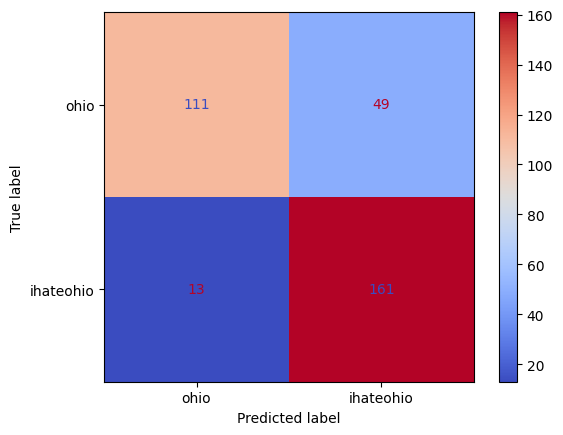

In [65]:
grid_search(cvec_lr, cvec_lr_params, 'CVec Logistic Regression')

In [66]:
cvec_lr_2 = Pipeline([
        ('cvec', CountVectorizer(stop_words=None, min_df=1)),
        ('lr', LogisticRegression(max_iter= 50_000, solver='saga', penalty='l1', random_state=42))
])

cvec_lr_params_2 = {
    'cvec__max_features': [1000, 1250, 1500],
    'cvec__max_df': [.6, .65, .7],
    'lr__C': [10, 20]}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'cvec__max_df': 0.6, 'cvec__max_features': 1500, 'lr__C': 10}  

Best Estimator Cross Val Score: 0.84033
CVec Logistic Regression_v2 Training Score: 0.92129
CVec Logistic Regression_v2 Testing Score: 0.82036
Misclassification Rate: 0.17964 

Best estimator confusion matrix:


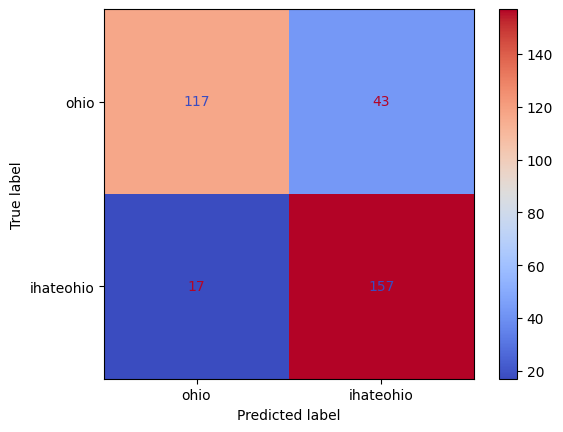

In [67]:
grid_search(cvec_lr_2, cvec_lr_params_2, 'CVec Logistic Regression_v2')

In [68]:
tfvec_lr = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('lr', LogisticRegression(max_iter= 50_000, solver='saga', penalty='l1', random_state=42))
])

tfvec_lr_params = {
    'tfvec__stop_words': [None, 'english'],
    'tfvec__max_features': [1000, 1250, 1500],
    'tfvec__max_df': [.6, .65, .7],
    'tfvec__min_df': [1, 2],
    'lr__C': [1, 10],

}

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'lr__C': 10, 'tfvec__max_df': 0.6, 'tfvec__max_features': 1500, 'tfvec__min_df': 1, 'tfvec__stop_words': None}  

Best Estimator Cross Val Score: 0.83883
TfVec Logistic Regression Training Score: 0.92429
TfVec Logistic Regression Testing Score: 0.83533
Misclassification Rate: 0.16467 

Best estimator confusion matrix:


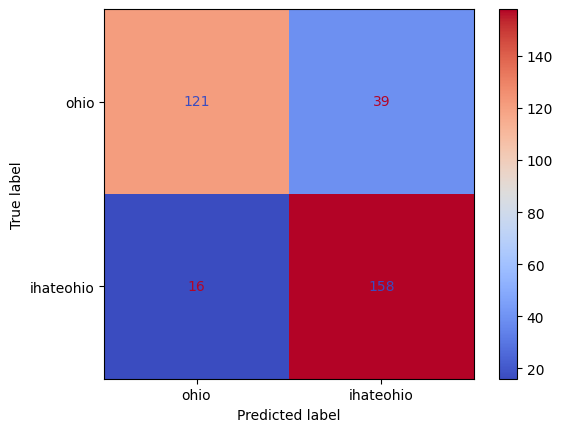

In [69]:
grid_search(tfvec_lr, tfvec_lr_params, 'TfVec Logistic Regression')

In [70]:
tfvec_lr_2 = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('lr', LogisticRegression(max_iter= 50_000, solver='saga', penalty='l1', random_state=42))
])

tfvec_lr_params_2 = {
    'tfvec__max_features': [1250, 1500, 1600, 1700],
    'tfvec__max_df': [.5, .55, .5],
    'tfvec__min_df': [1, 2],
    'lr__C': [1, 10],

}

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Params: {'lr__C': 10, 'tfvec__max_df': 0.5, 'tfvec__max_features': 1600, 'tfvec__min_df': 1}  

Best Estimator Cross Val Score: 0.84108
TfVec Logistic Regression_v2 Training Score: 0.92429
TfVec Logistic Regression_v2 Testing Score: 0.82934
Misclassification Rate: 0.17066 

Best estimator confusion matrix:


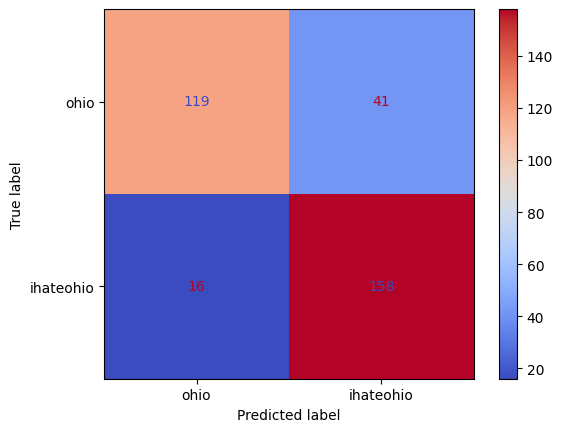

In [71]:
grid_search(tfvec_lr_2, tfvec_lr_params_2, 'TfVec Logistic Regression_v2')

### Analysis

Both LogReg models above that used CountVectorizer had similar train scores as when the model ran with no hyperparameters (5% decrease), but lower test scores than in the no-param model. We are definitely overfit here as well.

It seems that with tuning, Tfidf performs better than CVec on the Logistic Regression models versus the opposite pre-tuning. 

The lower CVec scores look like they are most coming from the IHateOhio subreddit. The models above are making a lot more false positive predictions, and about the same amount of false negative classifications.

---

## Multinomial Naive Bayes

In [72]:
cvec_mnb = Pipeline([
        ('cvec', CountVectorizer()),
        ('mnb', MultinomialNB())
])

cvec_mnb_params = {
    'cvec__max_features': [1500, 2000, 3000],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.7, .8],
    'mnb__fit_prior': [True, False],
    'mnb__alpha': [0, 0.5, 1]

}

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/Users/cynthiarodriguez/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/cynthiarodriguez/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/cynthiarodriguez/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/cynthiarodriguez/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/cynthiarodriguez/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  

Best Params: {'cvec__max_df': 0.7, 'cvec__max_features': 3000, 'cvec__min_df': 1, 'cvec__stop_words': None, 'mnb__alpha': 0.5, 'mnb__fit_prior': True}  

Best Estimator Cross Val Score: 0.86657
CVec MNB Training Score: 0.8958
CVec MNB Testing Score: 0.86228
Misclassification Rate: 0.13772 

Best estimator confusion matrix:


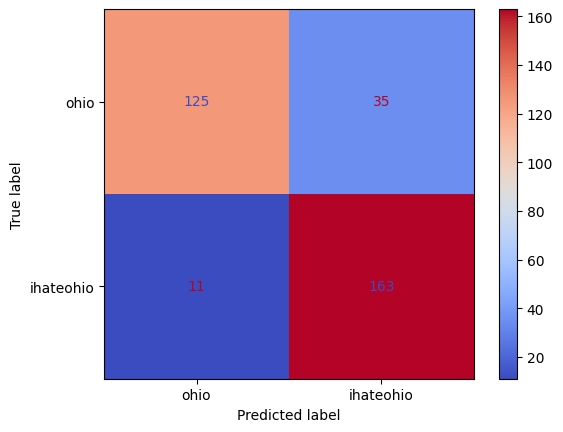

In [73]:
grid_search(cvec_mnb, cvec_mnb_params, 'CVec MNB')

In [74]:
cvec_mnb_2 = Pipeline([
        ('cvec', CountVectorizer(stop_words=None)),
        ('mnb', MultinomialNB())
])

cvec_mnb_params_2 = {
    'cvec__max_features': [2500, 3000, 3500, 4000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.65, .7, .75],
    'mnb__fit_prior': [True, False],
    'mnb__alpha': [0.5, 1]

}

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Params: {'cvec__max_df': 0.65, 'cvec__max_features': 3000, 'cvec__min_df': 1, 'mnb__alpha': 0.5, 'mnb__fit_prior': True}  

Best Estimator Cross Val Score: 0.86657
CVec MNB_v2 Training Score: 0.8958
CVec MNB_v2 Testing Score: 0.86228
Misclassification Rate: 0.13772 

Best estimator confusion matrix:


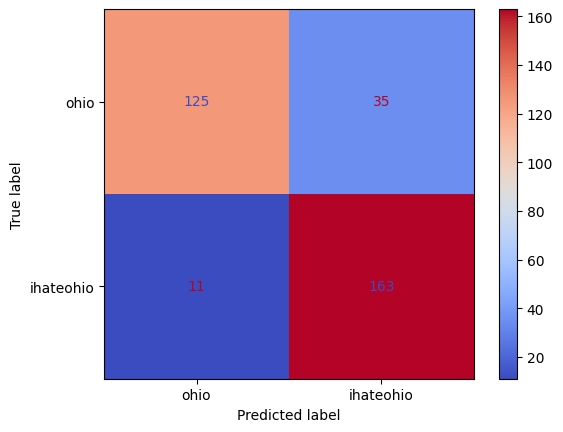

In [75]:
grid_search(cvec_mnb_2, cvec_mnb_params_2, 'CVec MNB_v2')

In [76]:
tfvec_mnb = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

tfvec_mnb_params = {
    'tfvec__stop_words': [None, 'english'],
    'tfvec__min_df': [1, 2],
    'tfvec__max_df': [.7, .8],
    'tfvec__ngram_range': [(1,1), (1,2)],
    'mnb__fit_prior': [True, False],
    'mnb__alpha': [0.5, 1]

}

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Params: {'mnb__alpha': 0.5, 'mnb__fit_prior': True, 'tfvec__max_df': 0.7, 'tfvec__min_df': 1, 'tfvec__ngram_range': (1, 1), 'tfvec__stop_words': 'english'}  

Best Estimator Cross Val Score: 0.86133
TfVec MNB Training Score: 0.91754
TfVec MNB Testing Score: 0.84731
Misclassification Rate: 0.15269 

Best estimator confusion matrix:


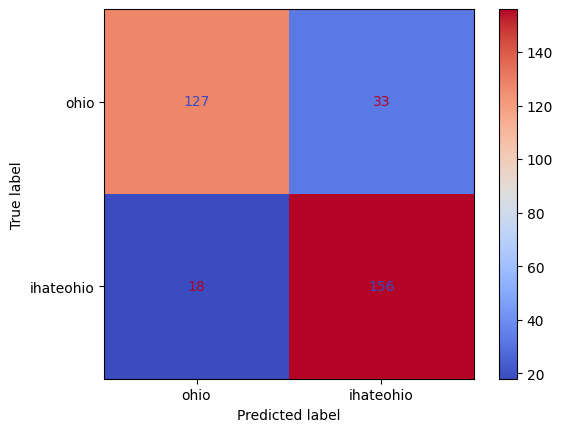

In [77]:
grid_search(tfvec_mnb, tfvec_mnb_params, 'TfVec MNB')

In [78]:
tfvec_mnb_2 = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

tfvec_mnb_params_2 = {
    'tfvec__stop_words': [None, 'english'],
    'tfvec__min_df': [1, 2],
    'tfvec__max_df': [.65, .7, .75],
    'mnb__fit_prior': [True, False],
    'mnb__alpha': [0.5, 1]

}

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Params: {'mnb__alpha': 0.5, 'mnb__fit_prior': True, 'tfvec__max_df': 0.65, 'tfvec__min_df': 1, 'tfvec__stop_words': 'english'}  

Best Estimator Cross Val Score: 0.86133
TfVec MNB_v2 Training Score: 0.91754
TfVec MNB_v2 Testing Score: 0.84731
Misclassification Rate: 0.15269 

Best estimator confusion matrix:


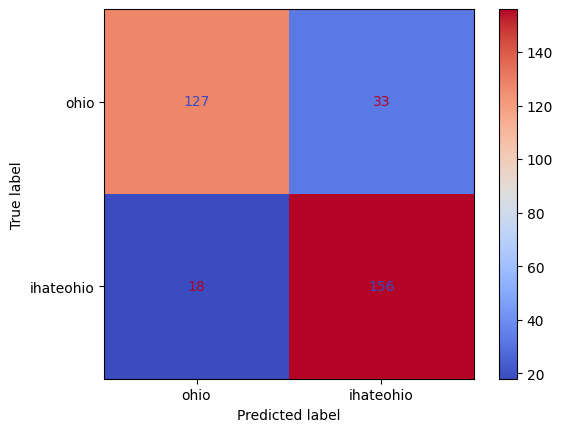

In [80]:
grid_search(tfvec_mnb_2, tfvec_mnb_params_2, 'TfVec MNB_v2')

### Analysis

Although we're early into the hypertuning trials, the two CVec MNB models above scored higher than all no-param models, as well as all four of the Logistic Regression models above.

It does not look like the hyperparameter tuning was necessary in the second iterations of CVec and Tfidf here - they scored exactly the same as the first versions.

There is still some overfitting that needs to be addressed, but overall, these are four strong models than can be further adjusted to hopefully decrease variance and improve accuracy.

---

## Gradient Boosting Classifier

In [85]:
cvec_gboost = Pipeline([
    ('cvec', CountVectorizer(stop_words=None)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

cvec_gboost_params  = {
    'cvec__max_features': [3000, 4000],
    'cvec__max_df': [.65, .7, .75],
    'gb__n_estimators': [100, 150, 200], 
    'gb__max_depth': [5, 7, 8],
    'gb__learning_rate': [0.7, 0.8] 
}

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Params: {'cvec__max_df': 0.65, 'cvec__max_features': 3000, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__n_estimators': 200}  

Best Estimator Cross Val Score: 0.85007
CVec GBoost Training Score: 0.92504
CVec GBoost Testing Score: 0.84132
Misclassification Rate: 0.15868 

Best estimator confusion matrix:


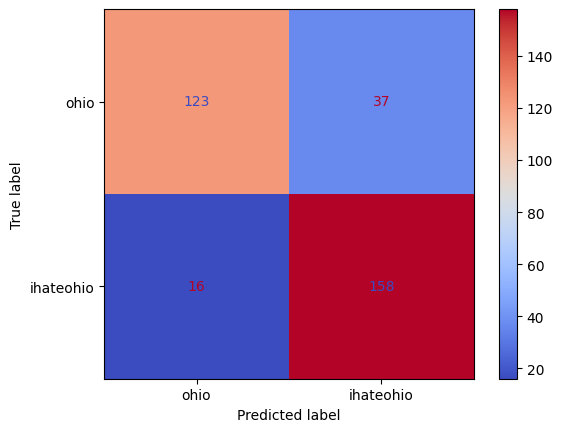

In [86]:
grid_search(cvec_gboost, cvec_gboost_params, 'CVec GBoost')

In [87]:
cvec_gboost_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words=None)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

cvec_gboost_params_2  = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__max_df': [.6, .65, .7],
    'gb__n_estimators': [200, 250, 300], 
    'gb__max_depth': [4, 5, 6],
    'gb__learning_rate': [0.7, 0.8] 
}

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Params: {'cvec__max_df': 0.6, 'cvec__max_features': 3500, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__n_estimators': 200}  

Best Estimator Cross Val Score: 0.85082
CVec GBoost_v2 Training Score: 0.92504
CVec GBoost_v2 Testing Score: 0.84132
Misclassification Rate: 0.15868 

Best estimator confusion matrix:


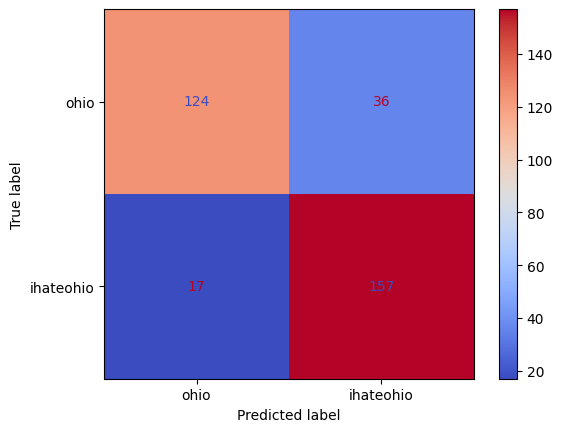

In [88]:
grid_search(cvec_gboost_2, cvec_gboost_params_2, 'CVec GBoost_v2')

In [89]:
tfvec_gboost = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

tfvec_gboost_params  = {
    'tfvec__stop_words': [None, 'english'],
    'gb__n_estimators': [100, 150, 200], 
    'gb__max_depth': [5, 7, 8],
    'gb__learning_rate': [0.7, 0.8, 0.85] 
}

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Params: {'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__n_estimators': 200, 'tfvec__stop_words': None}  

Best Estimator Cross Val Score: 0.85233
TfVec GBoost Training Score: 0.92579
TfVec GBoost Testing Score: 0.81737
Misclassification Rate: 0.18263 

Best estimator confusion matrix:


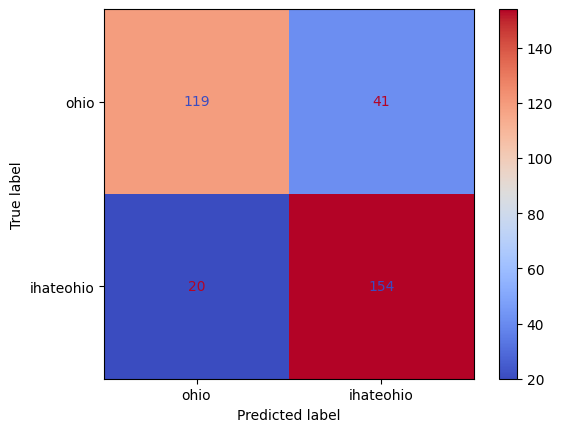

In [90]:
grid_search(tfvec_gboost, tfvec_gboost_params, 'TfVec GBoost')

In [91]:
tfvec_gboost_2 = Pipeline([
    ('tfvec', TfidfVectorizer(stop_words=None)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

tfvec_gboost_params_2  = {
    'gb__max_depth': [6, 7, 8],
    'gb__learning_rate': [0.7, 0.75, 0.8],
    'gb__validation_fraction': [.05, .1],
    'gb__n_iter_no_change': [5, 10, 20],
    'gb__tol': [.03, .05, .1]
}

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Params: {'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__n_iter_no_change': 20, 'gb__tol': 0.03, 'gb__validation_fraction': 0.1}  

Best Estimator Cross Val Score: 0.84333
TfVec GBoost_v2 Training Score: 0.91829
TfVec GBoost_v2 Testing Score: 0.82036
Misclassification Rate: 0.17964 

Best estimator confusion matrix:


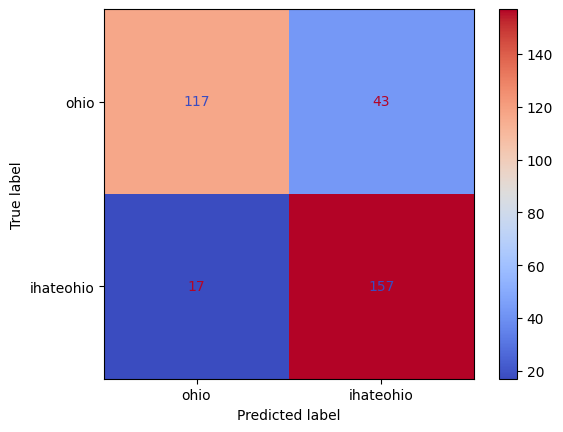

In [92]:
grid_search(tfvec_gboost_2, tfvec_gboost_params_2, 'TfVec GBoost_v2')

### Analysis

The GBoost models' performance above closely mirrored the scores seen on the no-param GBoost models, and scored higher than all but one no-param model overall. In the above tests, the ~0.84 CVec scores beat the original CVec value of 0.82934.

My theory is that while Decision Trees are a decently-strong scoring predictor, when used as the weak learner in GBoosting and weighed according to accuracy (my target metric), the model becomes a bit more adept and outscores both Decision Tree models on their own and Random Forest.

Because the Gradient Boost model has performed moderately well in all trials, I anticipate that I'll be using it in my final model.

---

## AdaBoost Classifier

In [93]:
cvec_ada = Pipeline([
        ('cvec', CountVectorizer()),
        ('ada', AdaBoostClassifier(random_state=42))
])

cvec_ada_params = {
    'cvec__stop_words': [None, 'english'],
    'ada__n_estimators': [100, 200, 300],
    'ada__learning_rate': [0.7, 0.8, 0.9],
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'ada__learning_rate': 0.8, 'ada__n_estimators': 200, 'cvec__stop_words': None}  

Best Estimator Cross Val Score: 0.84483
Cvec AdaBoost Training Score: 0.92504
Cvec AdaBoost Testing Score: 0.82335
Misclassification Rate: 0.17665 

Best estimator confusion matrix:


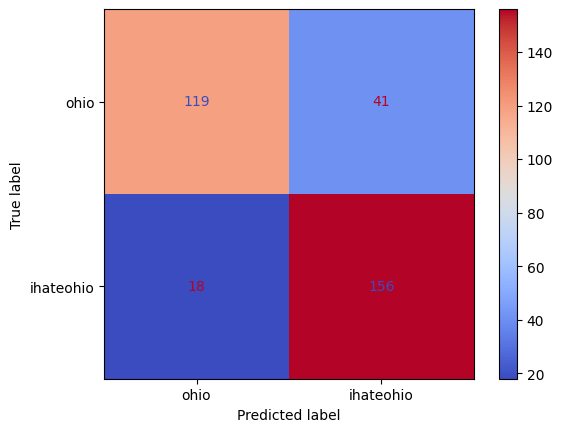

In [94]:
grid_search(cvec_ada, cvec_ada_params, 'Cvec AdaBoost')

In [95]:
cvec_ada_2 = Pipeline([
        ('cvec', CountVectorizer(stop_words=None)),
        ('ada', AdaBoostClassifier(random_state=42))
])

cvec_ada_params_2 = {
    'ada__n_estimators': [300, 350, 400],
    'ada__learning_rate': [0.6, 0.65, 0.7],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'ada__learning_rate': 0.7, 'ada__n_estimators': 300}  

Best Estimator Cross Val Score: 0.84182
CVec AdaBoost_v2 Training Score: 0.92579
CVec AdaBoost_v2 Testing Score: 0.82934
Misclassification Rate: 0.17066 

Best estimator confusion matrix:


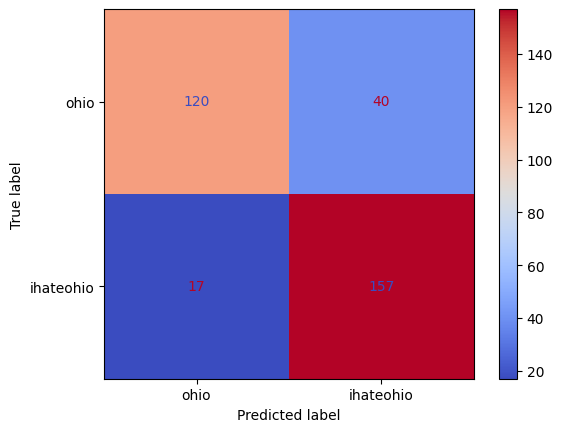

In [96]:
grid_search(cvec_ada_2, cvec_ada_params_2, 'CVec AdaBoost_v2')

In [97]:
tfvec_ada = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('ada', AdaBoostClassifier(random_state=42))
])

tfvec_ada_params = {
    'ada__n_estimators': [300, 350, 400],
    'ada__learning_rate': [0.6, 0.65, 0.7],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'ada__learning_rate': 0.65, 'ada__n_estimators': 400}  

Best Estimator Cross Val Score: 0.84184
TfVec AdaBoost Training Score: 0.92579
TfVec AdaBoost Testing Score: 0.82335
Misclassification Rate: 0.17665 

Best estimator confusion matrix:


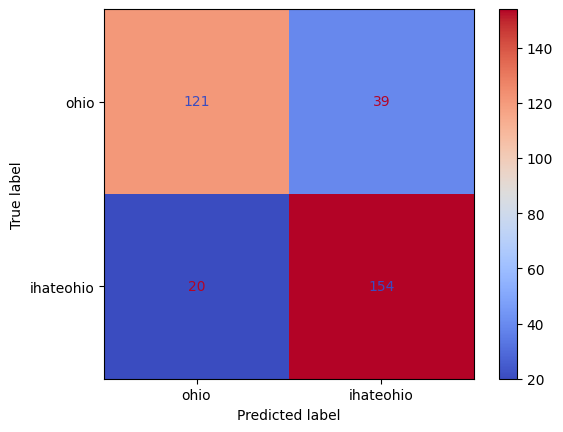

In [98]:
grid_search(tfvec_ada, tfvec_ada_params, 'TfVec AdaBoost')

In [99]:
tfvec_ada_2 = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('ada', AdaBoostClassifier(random_state=42))
])

tfvec_ada_params_2 = {
    'ada__n_estimators': [400, 450, 500],
    'ada__learning_rate': [0.6, 0.7, 0.8],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'ada__learning_rate': 0.6, 'ada__n_estimators': 500}  

Best Estimator Cross Val Score: 0.84109
TfVec AdaBoost_v2 Training Score: 0.92579
TfVec AdaBoost_v2 Testing Score: 0.81737
Misclassification Rate: 0.18263 

Best estimator confusion matrix:


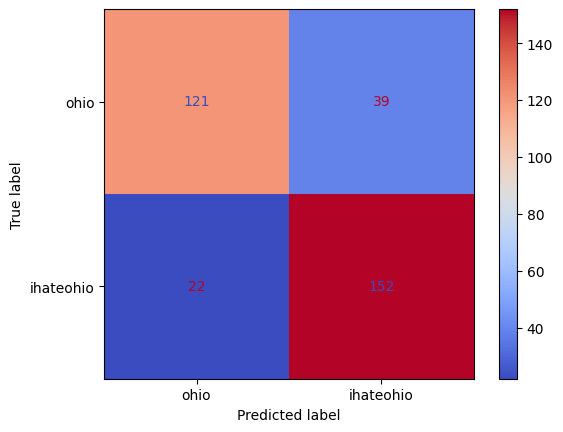

In [100]:
grid_search(tfvec_ada_2, tfvec_ada_params_2, 'TfVec AdaBoost_v2')

### Analysis

The CVec version 2 model above generated the same test score as the prior AdaBoost CVec and Tfidf models without paramaters. 

Because there is a trade-off between n_estimators and learning_rate, I inversely shifted the range of the two hyperparameters, and this specific model seemed to prefer the lower learning rate and higher amount of estimators (as did the TfVec model).

The three other models did not perform as well as the no-param CountVectorizer or Tfidf models. 

Though slightly under the GradientBoost top score, AdaBoost is another great option to test on the final model.

---

## Bagging Classifier

In [102]:
cvec_bag = Pipeline([
        ('cvec', CountVectorizer()),
        ('bag', BaggingClassifier(random_state=42))
])

cvec_bag_params = {
    'cvec__stop_words': [None, 'english'],
    'bag__n_estimators': [200, 400, 600],
    'bag__max_features': [200, 300, 400],
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'bag__max_features': 400, 'bag__n_estimators': 400, 'cvec__stop_words': None}  

Best Estimator Cross Val Score: 0.82759
CVec Bagging Training Score: 0.8943
CVec Bagging Testing Score: 0.8024
Misclassification Rate: 0.1976 

Best estimator confusion matrix:


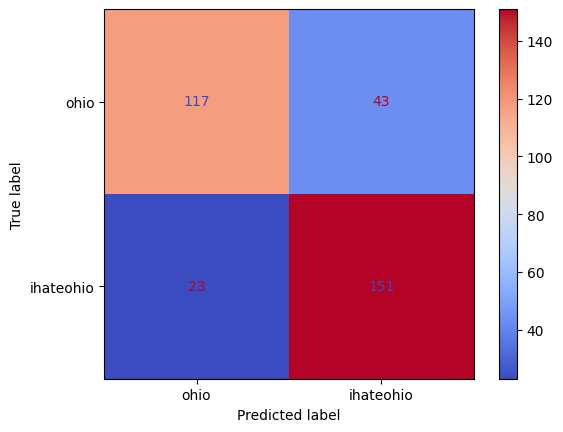

In [103]:
grid_search(cvec_bag, cvec_bag_params, 'CVec Bagging')

In [104]:
cvec_bag_2 = Pipeline([
        ('cvec', CountVectorizer()),
        ('bag', BaggingClassifier(random_state=42))
])

cvec_bag_params_2 = {
    'cvec__stop_words': [None, 'english'],
    'bag__n_estimators': [200, 400, 600],
    'bag__max_samples': [300, 400, 500], 
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'bag__max_samples': 400, 'bag__n_estimators': 200, 'cvec__stop_words': None}  

Best Estimator Cross Val Score: 0.83283
CVec Bagging_v2 Training Score: 0.86057
CVec Bagging_v2 Testing Score: 0.82335
Misclassification Rate: 0.17665 

Best estimator confusion matrix:


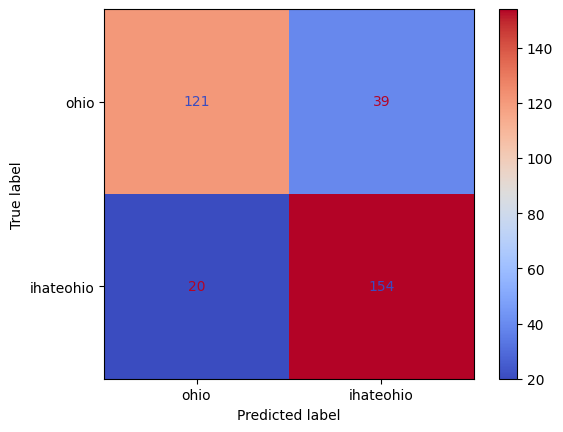

In [105]:
grid_search(cvec_bag_2, cvec_bag_params_2, 'CVec Bagging_v2')

In [106]:
tfvec_bag = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('bag', BaggingClassifier(random_state=42))
])

tfvec_bag_params = {
    'bag__n_estimators': [100, 150, 200],
    'bag__max_samples': [300, 400, 500], 
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'bag__max_samples': 500, 'bag__n_estimators': 150}  

Best Estimator Cross Val Score: 0.83283
TfVec Bagging Training Score: 0.88306
TfVec Bagging Testing Score: 0.81437
Misclassification Rate: 0.18563 

Best estimator confusion matrix:


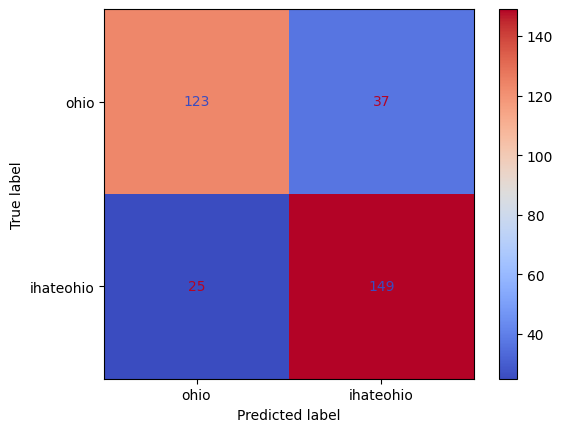

In [107]:
grid_search(tfvec_bag, tfvec_bag_params, 'TfVec Bagging')

### Analysis

The best-performing model above was the second version of the CVec model. 

I updated the hyperparameters because max_samples pulls samples with replacement but max_features does not. Making this change looks to have decreased the false positives and increased the number of Ohio predictions.

The Tfidf model scored slightly worse with hyperparameters added, dropping from a previous 0.81736 to 0.81437.

Regardless, I think that bagging would be effective in a stacked model, so I'll likely use the CVec version 2 above as one of the level-one estimators.

---

## Decision Tree Classifier

In [108]:
cvec_dtree = Pipeline([
        ('cvec', CountVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

cvec_dtree_params = {
        'cvec__stop_words': [None, 'english'],
        'dt__max_depth': [2, 3, 4],
        'dt__max_features': [1500, 2000, 3000, 'sqrt'] 
}

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params: {'cvec__stop_words': None, 'dt__max_depth': 4, 'dt__max_features': 3000}  

Best Estimator Cross Val Score: 0.82009
CVec Decision Tree Training Score: 0.83883
CVec Decision Tree Testing Score: 0.7994
Misclassification Rate: 0.2006 

Best estimator confusion matrix:


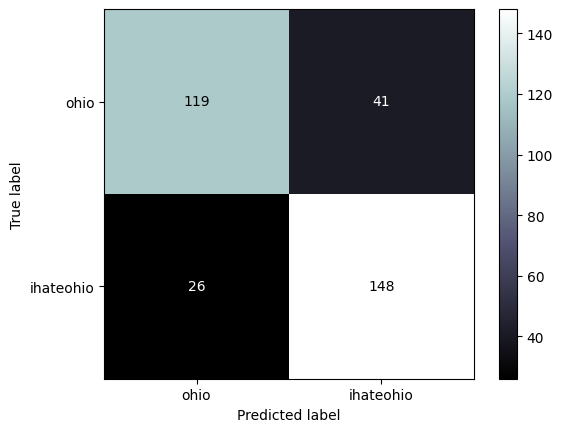

In [109]:
grid_search(cvec_dtree, cvec_dtree_params, 'CVec Decision Tree')

In [110]:
cvec_dtree_2 = Pipeline([
        ('cvec', CountVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

cvec_dtree_params_2 = {
        'dt__max_depth': [4, 5, 7],
        'dt__max_features': [2500, 3000, 3500, 4000, 5000]
}

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'dt__max_depth': 5, 'dt__max_features': 3500}  

Best Estimator Cross Val Score: 0.82684
CVec Decision Tree_v2 Training Score: 0.85757
CVec Decision Tree_v2 Testing Score: 0.81737
Misclassification Rate: 0.18263 

Best estimator confusion matrix:


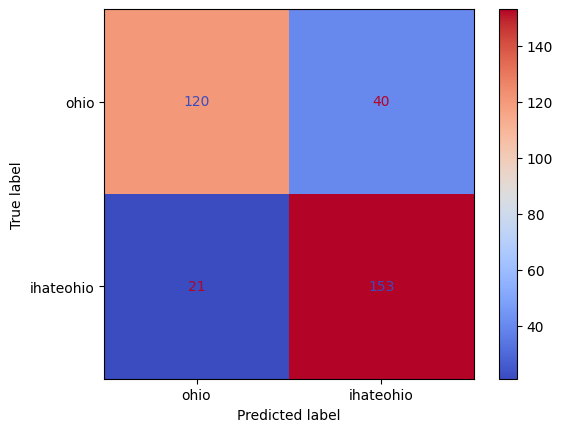

In [111]:
grid_search(cvec_dtree_2, cvec_dtree_params_2, 'CVec Decision Tree_v2')

In [112]:
tfvec_dtree = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

tfvec_dtree_params = {
        'dt__max_depth': [5, 6, 7],
        'dt__max_features': [1500, 2000, 3000, 3500, 'sqrt']
}

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'dt__max_depth': 5, 'dt__max_features': 3500}  

Best Estimator Cross Val Score: 0.82009
TfVec Decision Tree Training Score: 0.86882
TfVec Decision Tree Testing Score: 0.80838
Misclassification Rate: 0.19162 

Best estimator confusion matrix:


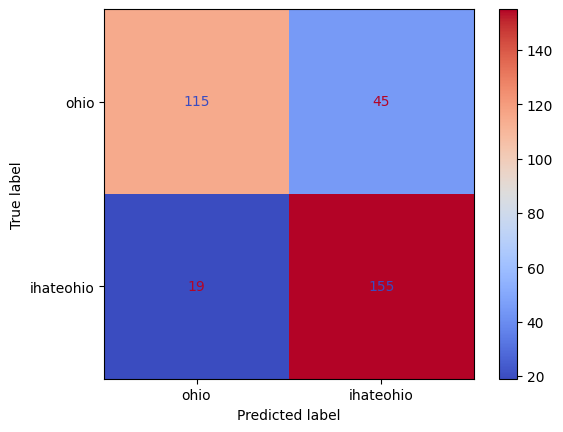

In [113]:
grid_search(tfvec_dtree, tfvec_dtree_params, 'TfVec Decision Tree')

In [114]:
tfvec_dtree_2 = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

tfvec_dtree_params_2 = {
        'dt__max_depth': [4, 5, 6],
        'dt__max_features': [2000, 3000, 4000]
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'dt__max_depth': 4, 'dt__max_features': 3000}  

Best Estimator Cross Val Score: 0.81934
TfVec Decision Tree_v2 Training Score: 0.84783
TfVec Decision Tree_v2 Testing Score: 0.81138
Misclassification Rate: 0.18862 

Best estimator confusion matrix:


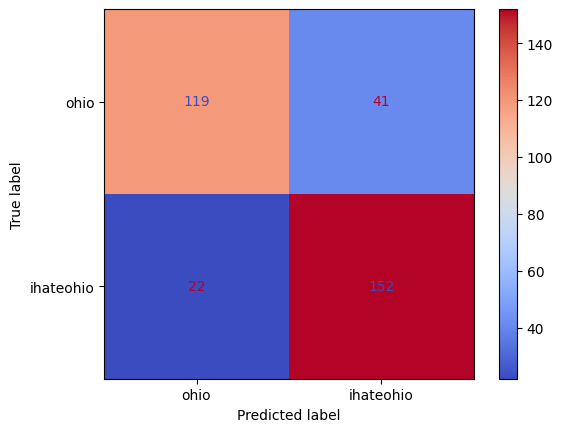

In [115]:
grid_search(tfvec_dtree_2, tfvec_dtree_params_2, 'TfVec Decision Tree_v2')

### Analysis

My original strategy of being conservative with the amount of features allowed in the model did not seem to pay off. 

After increasing the depth and feature range, the CVec model performed a lot better, and matched the score of the untuned model. The Tfidf did see a dip in the train score, but also a slight improvement in the test score compared to the first model.

These scores aren't quite as high as the others, so I probably will not use Decision Tree classification in my final model.

---

## Random Forest Classifier

In [117]:
cvec_rf = Pipeline([
        ('cvec', CountVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
])

cvec_rf_params = {
        'cvec__stop_words': [None, 'english'],
        'rf__max_depth': [5, 6, 7],
        'rf__n_estimators': [1000, 1500, 2000, 'sqrt'],
        'rf__max_samples': [500, 1000, None]
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'cvec__stop_words': None, 'rf__max_depth': 7, 'rf__max_samples': 500, 'rf__n_estimators': 1000}  

Best Estimator Cross Val Score: 0.81784
CVec Random Forest Training Score: 0.82459
CVec Random Forest Testing Score: 0.8024
Misclassification Rate: 0.1976 

Best estimator confusion matrix:


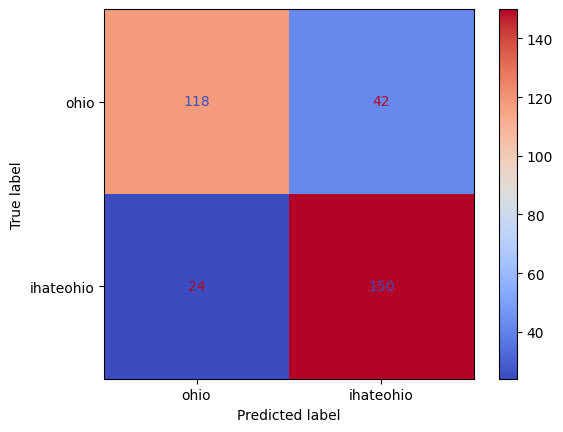

In [118]:
grid_search(cvec_rf, cvec_rf_params, 'CVec Random Forest')

In [119]:
cvec_rf_2 = Pipeline([
        ('cvec', CountVectorizer(stop_words=None)),
        ('rf', RandomForestClassifier(random_state=42))
])

cvec_rf_params_2 = {
        'rf__max_depth': [6, 7, 8],
        'rf__n_estimators': [800, 1000, 1500],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'rf__max_depth': 8, 'rf__n_estimators': 800}  

Best Estimator Cross Val Score: 0.82084
CVec Random Forest_v2 Training Score: 0.84633
CVec Random Forest_v2 Testing Score: 0.8024
Misclassification Rate: 0.1976 

Best estimator confusion matrix:


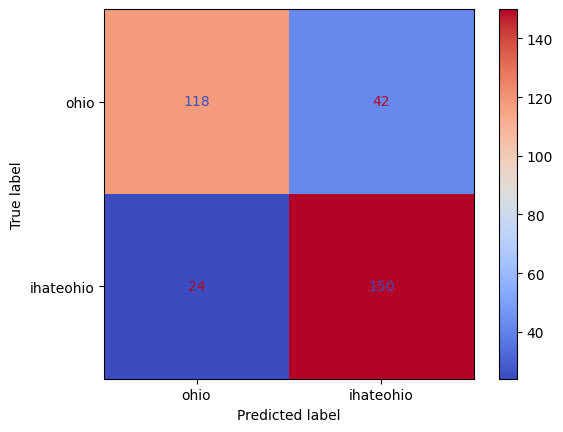

In [120]:
grid_search(cvec_rf_2, cvec_rf_params_2, 'CVec Random Forest_v2')

In [121]:
tfvec_rf = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
])

tfvec_rf_params = {
        'rf__max_depth': [6, 7, 8],
        'rf__n_estimators': [800, 1000, 1500],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'rf__max_depth': 7, 'rf__n_estimators': 800}  

Best Estimator Cross Val Score: 0.81709
TfVec Random Forest Training Score: 0.84183
TfVec Random Forest Testing Score: 0.80539
Misclassification Rate: 0.19461 

Best estimator confusion matrix:


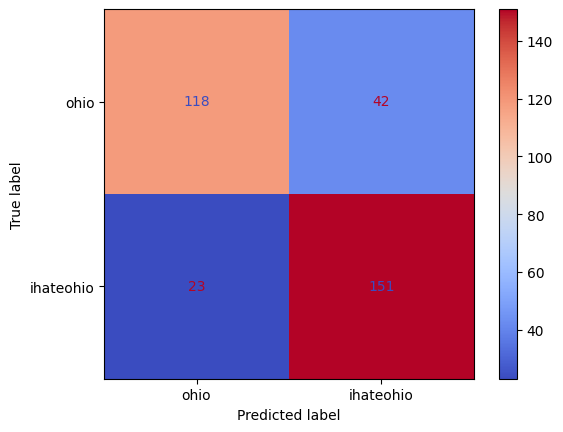

In [122]:
grid_search(tfvec_rf, tfvec_rf_params, 'TfVec Random Forest')

### Analysis

I was somewhat surprised here, because the Random Forest model made almost the same prediction three times, and scored about the same on all test sets in the three trials, even with varied 'best_params.' 

It underperformed compared to a few of the Decision Tree models above, and also scored worse than the RF models without hyperparameters. 

There are other stronger models seen above, so I will not be moving forward with RF trials.

---

## Model Evaluation

In [123]:
grid_search_df.to_csv('../datasets/model_tuning_no_https.csv')

grid_search_df

,model_used,cross_val_score,train_score,test_score,misclass_rate,best_param_1,best_param_2,best_param_3,best_param_4,best_param_5,best_param_6
0,CVec Logistic Regression,0.844078,0.878561,0.814371,0.185629,"(cvec__max_df, 0.7)","(cvec__max_features, 2000)","(cvec__min_df, 1)","(cvec__stop_words, None)","(lr__C, 0.1)","(lr__penalty, l2)"
1,CVec Logistic Regression_v2,0.840328,0.921289,0.820359,0.179641,"(cvec__max_df, 0.6)","(cvec__max_features, 1500)","(lr__C, 10)",-,-,-
2,TfVec Logistic Regression,0.838830,0.924288,0.835329,0.164671,"(lr__C, 10)","(tfvec__max_df, 0.6)","(tfvec__max_features, 1500)","(tfvec__min_df, 1)","(tfvec__stop_words, None)",-
3,TfVec Logistic Regression_v2,0.841079,0.924288,0.829341,0.170659,"(lr__C, 10)","(tfvec__max_df, 0.5)","(tfvec__max_features, 1600)","(tfvec__min_df, 1)",-,-
4,CVec MNB,0.866574,0.895802,0.862275,0.137725,"(cvec__max_df, 0.7)","(cvec__max_features, 3000)","(cvec__min_df, 1)","(cvec__stop_words, None)","(mnb__alpha, 0.5)","(mnb__fit_prior, True)"
5,CVec MNB_v2,0.866574,0.895802,0.862275,0.137725,"(cvec__max_df, 0.65)","(cvec__max_features, 3000)","(cvec__min_df, 1)","(mnb__alpha, 0.5)","(mnb__fit_prior, True)",-
6,TfVec MNB,0.861325,0.917541,0.847305,0.152695,"(mnb__alpha, 0.5)","(mnb__fit_prior, True)","(tfvec__max_df, 0.7)","(tfvec__min_df, 1)","(tfvec__ngram_range, (1, 1))","(tfvec__stop_words, english)"
7,TfVec MNB_v2,0.861325,0.917541,0.847305,0.152695,"(mnb__alpha, 0.5)","(mnb__fit_prior, True)","(tfvec__max_df, 0.65)","(tfvec__min_df, 1)","(tfvec__stop_words, english)",-
8,CVec GBoost,0.850067,0.925037,0.841317,0.158683,"(cvec__max_df, 0.65)","(cvec__max_features, 3000)","(gb__learning_rate, 0.7)","(gb__max_depth, 5)","(gb__n_estimators, 200)",-
9,CVec GBoost_v2,0.850822,0.925037,0.841317,0.158683,"(cvec__max_df, 0.6)","(cvec__max_features, 3500)","(gb__learning_rate, 0.7)","(gb__max_depth, 6)","(gb__n_estimators, 200)",-


In [124]:
grid_search_df.describe()

,cross_val_score,train_score,test_score,misclass_rate
count,26.000000,26.000000,26.000000,26.000000
mean,0.839293,0.893669,0.823814,0.176186
std,0.015197,0.034432,0.017777,0.017777
min,0.817088,0.824588,0.799401,0.137725
25%,0.827024,0.862631,0.812126,0.166168
50%,0.841086,0.906672,0.820359,0.179641
75%,0.848758,0.924850,0.833832,0.187874
max,0.866574,0.925787,0.862275,0.200599


The average accuracy among these test scores was 0.824, a modest increase from the untuned models' average of 0.790, and would likely be even greater without the one lower score from the first CVec Decision Tree model.

I do think that a few of these models are overfit, but the mean standard deviation for test and train scores are notable improvements in performance from the previous models. In theory, this means that these models are more predictable and, I'd guess, would score over 0.85 on the test set at least 10% of the time.

I'm going to combine a few of the top-scoring models into a stacked final model to hopefully further increase the scores.

In [125]:
grid_search_df[['model_used', 'test_score']].sort_values(by=['test_score'], ascending=False).head(10)

,model_used,test_score
4,CVec MNB,0.862275
5,CVec MNB_v2,0.862275
7,TfVec MNB_v2,0.847305
6,TfVec MNB,0.847305
9,CVec GBoost_v2,0.841317
8,CVec GBoost,0.841317
2,TfVec Logistic Regression,0.835329
13,CVec AdaBoost_v2,0.829341
3,TfVec Logistic Regression_v2,0.829341
12,Cvec AdaBoost,0.823353


---

## Interpretation

I'll now be using the CVec Multinomial Naive Bayes model to pull out the log coefficients of the data, and answer an aspect of my problem statement: can the data be used to identify what people like or do not like about Ohio?

In [7]:
# Reestablishing X and y
X = reddit['selftext']
y = reddit['subreddit_class'] # Not splitting into train/test here because I won't be scoring the model

In [8]:
# Setting the hyperparameters to the top-performing model's
cvec = CountVectorizer(max_df=0.7, max_features=3000, min_df=1) 
new_feats = cvec.fit_transform(X)

mnb = MultinomialNB(alpha=0.5, fit_prior=True)
mnb.fit(new_feats, y)

MultinomialNB(alpha=0.5)

In [9]:
words = cvec.get_feature_names_out()

neg_zipped_words = list(zip(words, mnb.feature_log_prob_[0]))
neg_sorted = sorted(neg_zipped_words, key=lambda t: t[1], reverse=True)
neg_words = pd.DataFrame(neg_sorted, columns=['ohio_words', 'ohio_coefs'])

pos_zipped_words = list(zip(words, mnb.feature_log_prob_[1]))
pos_sorted = sorted(pos_zipped_words, key=lambda t: t[1], reverse=True)
pos_words = pd.DataFrame(pos_sorted, columns=['ihateohio_words', 'ihateohio_coefs'])

all_words = pd.concat([neg_words, pos_words], axis=1)
all_words.head(20)

,ohio_words,ohio_coefs,ihateohio_words,ihateohio_coefs
0,to,-3.270002,the,-3.277284
1,the,-3.339775,ohio,-3.673221
2,and,-3.534959,and,-3.677607
3,in,-3.964086,to,-3.717972
4,of,-4.109014,it,-4.001847
5,it,-4.212371,of,-4.084172
6,is,-4.275149,is,-4.256641
7,for,-4.290614,in,-4.338319
8,my,-4.443755,that,-4.644613
9,that,-4.480758,just,-4.716500


These are the top 20 coefficients for predicting both classes (note: all numbers are negative as these are log probabilities). The table is rather uninteresting and made up almost entirely of stopwords. These were intentionally not excluded, because the MNB grid search indicated that it scored highest when stopwords were not set. 

Not only do the two classes share eight out of their top ten words, the coefficient values are also very similar. What we can infer here is that when the word 'ohio' is used, the probability that the post is from the IHateOhio subreddit is greater than the probability that it is from the Ohio thread.

For the sake of curiosity and more inference, I'll be running the same model below with stopwords removed this time to see if this aids our ability to interpret the importance of the words in the model.

In [12]:
cvec = CountVectorizer(max_df=0.7, max_features=3000, min_df=1, stop_words='english') 
new_feats = cvec.fit_transform(X)

mnb = MultinomialNB(alpha=0.5, fit_prior=True)
mnb.fit(new_feats, y)

MultinomialNB(alpha=0.5)

In [13]:
no_stopwords = cvec.get_feature_names_out()

neg_zipped_words = list(zip(no_stopwords, mnb.feature_log_prob_[0]))
neg_sorted = sorted(neg_zipped_words, key=lambda t: t[1], reverse=True)
neg_words = pd.DataFrame(neg_sorted, columns=['ohio_words', 'ohio_coefs'])

pos_zipped_words = list(zip(no_stopwords, mnb.feature_log_prob_[1]))
pos_sorted = sorted(pos_zipped_words, key=lambda t: t[1], reverse=True)
pos_words = pd.DataFrame(pos_sorted, columns=['ihateohio_words', 'ihateohio_coefs'])

all_non_stopwords = pd.concat([neg_words, pos_words], axis=1)
all_non_stopwords.head(20)

,ohio_words,ohio_coefs,ihateohio_words,ihateohio_coefs
0,ohio,-4.155399,ohio,-3.071558
1,just,-4.288229,just,-4.114837
2,know,-4.643570,state,-4.486711
3,like,-4.681618,people,-4.542281
4,people,-4.961024,like,-4.601122
5,don,-5.085699,fuck,-4.777401
6,ve,-5.110911,fucking,-4.777401
7,state,-5.154396,hate,-4.933562
8,looking,-5.218638,shit,-5.188908
9,time,-5.257290,place,-5.264416


The above dataframe gives us more thought-provoking information on which words the model looks for to predict the class. Again, the word 'ohio' is a clear indicator of the IHateOhio subreddit. We do see a lot similarities between the two threads here, but the contrast also becomes more distinct with the expletives, words like "hate" and "bad," and less obvious words like "michigan."

To address the original question of, can this data be used to ascertain any information about what people like or dislike about Ohio, I think the answer is no. There are very few mentions of any monuments, things to do, or attributes of the state. The data above does not give us much to go on, and by the time we get to the more interesting words, the log probs will likely be low enough that there is not a classification/probability effect worth noting.

---

## Stacking Best Models

In [14]:
X = reddit['selftext']
y = reddit['subreddit_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

### MNB & Gradient Boosting

In [127]:
level1_est = [
    ('mnb_pipe', Pipeline([
        ('cvec', CountVectorizer(max_df=0.7, max_features=3000, min_df=1)),
        ('mnb', MultinomialNB(alpha=0.5))
    ])),
    ('gb_pipe', Pipeline([
        ('cvec', CountVectorizer(max_df=0.6, max_features=3500)),
        ('gb', GradientBoostingClassifier(learning_rate=0.7, max_depth=6, n_estimators=200))
    ]))
]

stacked_model = StackingClassifier(estimators=level1_est, final_estimator=LogisticRegression(solver='saga', C=10, penalty='l1'))

In [128]:
print(cross_val_score(stacked_model, X_train, y_train).mean())
stacked_model.fit(X_train, y_train)

0.8687984004956212


StackingClassifier(estimators=[('mnb_pipe',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_df=0.7,
                                                                 max_features=3000)),
                                                ('mnb',
                                                 MultinomialNB(alpha=0.5))])),
                               ('gb_pipe',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_df=0.6,
                                                                 max_features=3500)),
                                                ('gb',
                                                 GradientBoostingClassifier(learning_rate=0.7,
                                                                            max_depth=6,
                                                                            n_estimators=200))]))],
                   final_estimator=LogisticRegression(C=10, penalty='l1',
                                                      solver='saga'))

In [129]:
print(f'Training score: {stacked_model.score(X_train, y_train)}')
print(f'Testing score: {stacked_model.score(X_test, y_test)}')

Training score: 0.9137931034482759
Testing score: 0.8562874251497006


These are the two highest-scoring models combined, with Logistic Regression included as the final estimator. It scored well, but just under the original MNB model score of 0.862275. 

### AdaBoosting & Bagging

In [131]:
level1_est2 = [
    ('ada_pipe', Pipeline([
        ('cvec', CountVectorizer()),
        ('ada', AdaBoostClassifier(learning_rate=0.7, n_estimators=300, random_state=42))
    ])),
    ('bag_pipe', Pipeline([
        ('cvec', CountVectorizer()),
        ('bag', BaggingClassifier(max_samples=400, n_estimators=200, random_state=42))
    ]))
]

stacked_model_2 = StackingClassifier(estimators=level1_est2, final_estimator=LogisticRegression(solver='saga', C=10, penalty='l1', random_state=42))

In [132]:
print(cross_val_score(stacked_model_2, X_train, y_train).mean())
stacked_model_2.fit(X_train, y_train)

0.8470558418518206


StackingClassifier(estimators=[('ada_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('ada',
                                                 AdaBoostClassifier(learning_rate=0.7,
                                                                    n_estimators=300,
                                                                    random_state=42))])),
                               ('bag_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('bag',
                                                 BaggingClassifier(max_samples=400,
                                                                   n_estimators=200,
                                                                   random_state=42))]))],
                   final_estimator=LogisticRegression(C=10, penalty='l1',
                                                      random_state=42,
                                                      solver='saga'))

In [133]:
print(f'Training score: {stacked_model_2.score(X_train, y_train)}')
print(f'Testing score: {stacked_model_2.score(X_test, y_test)}')

Training score: 0.9100449775112444
Testing score: 0.8233532934131736


My thought process here was that combining a Booster and a Bagging model would increase bias while simultaneously decreasing variance, but this model scored worse than the AdaBoost model on its own.

### MNB & Bagging

In [134]:
level1_est3 = [
    ('mnb_pipe', Pipeline([
        ('cvec', CountVectorizer(max_df=0.7, max_features=3000, min_df=1)),
        ('mnb', MultinomialNB(alpha=0.5))
    ])),
    ('bag_pipe', Pipeline([
        ('cvec', CountVectorizer()),
        ('bag', BaggingClassifier(max_samples=400, n_estimators=200, random_state=42))
    ]))
]

stacked_model_3 = StackingClassifier(estimators=level1_est3, final_estimator=LogisticRegression(solver='saga', C=10, penalty='l1'))

In [135]:
print(cross_val_score(stacked_model_3, X_train, y_train).mean())
stacked_model_3.fit(X_train, y_train)

0.8612964996761567


StackingClassifier(estimators=[('mnb_pipe',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_df=0.7,
                                                                 max_features=3000)),
                                                ('mnb',
                                                 MultinomialNB(alpha=0.5))])),
                               ('bag_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('bag',
                                                 BaggingClassifier(max_samples=400,
                                                                   n_estimators=200,
                                                                   random_state=42))]))],
                   final_estimator=LogisticRegression(C=10, penalty='l1',
                                                      solver='saga'))

In [136]:
print(f'Training score: {stacked_model_3.score(X_train, y_train)}')
print(f'Testing score: {stacked_model_3.score(X_test, y_test)}')

Training score: 0.896551724137931
Testing score: 0.8502994011976048


This model has less variance than the two above, but a lower test score than the MNB/Gradient Boost model. 

---

## Conclusion

The stacked models performed well, but did not beat the first tuned CountVectorizer Multinomial Naive Bayes model above. This means that the final overall model to move forward with in my classification tasks for the state of Ohio is the MNB Classifier, using CountVectorizer, a max document frequency of 0.7, max features set to 3,000,  a minimum document frequency of 1, and the MNB alpha set to 0.5. 

MNB and Logistic Regression both consistently scored well compared to the other models, with and without hyperparameters. I think one reason why MNB edged forward after model tuning is that it is a generative model (as opposed to LogReg, which is a discriminative model). This means that in general, MNB needs less data to train versus LR, and is more biased toward feature independence.

Something to note is that most of the models before and after tuning are overfit. Even with Bagging and Boosting, the average difference between the train and test scores here was about 0.07. While not dramatically different, this is still a greater gap than I'd want there to be when modeling in the real world.

However, the scores with edited hyperparameters did become more consistent. The standard deviation of 0.0178 tells us that we can reasonably expect an average score of 0.8238, within a +/- 0.0178 margin.

I was surprised at a few of the models that did not score as well as the no-parameter versions. I think this is probably in part due to user error - I may not be entering the most optimal values into the pipelines, and the models may be scoring as high as they can with what I'm feeding into them. I also think that very intelligent people created the models to begin with, and have programmed the default hyperparameters to be the values that work the best on most sets of data.

Overall, I'm happy with the scores of the tuned models, and I have at least one that could reliably be used to classify posts correctly 85% of the time. However, I would call into question the value of the data that is being pulled. We may have working models, but this is irrelevant if we are looking for information in the wrong place. From what I've seen during EDA, model trials, inference, and just looking through many of the posts directly in the dataframe, Reddit does not appear to be a site where people go to share things that they enjoy about Ohio. There are many people who share their dislikes, but very few have to do with anything that our advertising team can fix or market to. To this end, not all of the objectives of my problem statement were attained, as I can not confidently say that we would be able to use the scraped data as guidance for our team.

The next steps I would take are:
- Pulling data out of websites like TripAdvisor or Yelp, where people are reviewing specific places or experiences in Ohio.
- Clean and preprocess the data further e.g. include lemmatizers in the model trials and add in more custom stop words.
- Make sure to investigate the misclassified posts. Based on what we saw with these results, I think there are sometimes patterns that can be identified and accounted for in the model.
- Further model trials and testing; running with additional hyperparameters. Focus on decreasing variance.
- After all of the above, implementation of the best-scoring model to pull out any notable material that is being said about Ohio on more review-based websites, then advising our marketing team to mention or not mention said points in our ads.